
# Donor Availability Predictor 


**Objective**: Predict whether a donor is **Available** and export a final model + tiny metrics for a Streamlit demo app.

**Dataset**: `data/Blood_Donor_updated.csv`  
**Target**: `availability` (Yes/No → 1/0)

**What you'll get by the end:**
- A small **leaderboard** across 3 simple models (LogReg, RandomForest, SVC-RBF)
- A **chosen model** evaluated on a test set
- Saved artifacts for the app:
  - `models/final_model.pkl`
  - `models/metrics.json`



## Step 0 — Setup: imports & paths
**Why this step?** We import just what we need and define where data and artifacts live. Keeping paths up top makes the notebook portable.

**Advantages**
- Reproducible file structure
- Easy to switch environments (Colab/VS Code)

In [1]:

import os, json, warnings, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

ROOT = Path('.').resolve()
DATA = ROOT / 'data' / 'Blood_Donor_updated.csv'
MODELS_DIR = ROOT / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print('Project root:', ROOT)
print('Dataset path :', DATA)
print('Models dir   :', MODELS_DIR)


Project root: C:\Users\danan\Downloads\donor_app_full (3)
Dataset path : C:\Users\danan\Downloads\donor_app_full (3)\data\Blood_Donor_updated.csv
Models dir   : C:\Users\danan\Downloads\donor_app_full (3)\models



## Step 1 — Load dataset
**What we do:** Read the CSV, peek at shape and a few rows.

**Advantages**
- Quick validation that the file is reachable
- Early sense of column names & types

In [2]:

df = pd.read_csv(DATA)
print('Initial shape:', df.shape)
df.head()


Initial shape: (10021, 12)


,donor_id,name,email,password,contact_number,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
0,1b8b4c828a,Norma Fisher,ysullivan@yahoo.com,P5hX6Syg*A,+61 461706749,Hobart,A+,No,65.0,31.0,62.0,2017-03-17
1,ID_2,Eugene Bowman,hramos@brown-sellers.com,b6Wq6Cqz@5,+61 450709944,Unknown,AB-,NaN,64.0,8.0,16.0,2016-11-11
2,cee6478144,Sheri Bolton DDS,jasmine85@hotmail.com,$9RB51m#s7,+61 428756361,Melbourne,AB+,Yes,NaN,6.0,6.0,2022-02-25
3,5986bc55f9,Kelly Boyd,pattylawrence@riley-hayes.com,@5Tdg(4kCm,+61 454318320,Darwin,A-,No,55.0,20.0,20.0,2025-04-04
4,93246afe6c,Taylor Guzman,martinezjacob@wilson.com,x!)9Ag@J*7,NaN,Darwin,O-,No,7.0,35.0,35.0,2022-11-30



## Step 2 — Remove duplicates
**What we do:** Drop duplicate rows (if any).

**Advantages**
- Prevent duplicated signals from biasing the model
- Keeps metrics honest

In [3]:

before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f'Removed {before - after} duplicate rows | New shape: {df.shape}')


Removed 11 duplicate rows | New shape: (10010, 12)



## Step 3 — Light NA handling (target only)
**What we do:** Ensure `availability` exists and drop rows where it's missing. We let the **model pipeline** impute feature NAs later.

**Advantages**
- Minimal data loss
- Centralized imputation in one place (the pipeline)

In [4]:

TARGET = 'availability'
if TARGET not in df.columns:
    raise ValueError('Target column "availability" not found. Confirm the dataset schema.')

drop_before = df.shape[0]
df = df.dropna(subset=[TARGET])
print(f'Dropped rows with missing target: {drop_before - df.shape[0]}')
print('Current shape:', df.shape)


Dropped rows with missing target: 459
Current shape: (9551, 12)



## Step 4 — Light outlier filter (IQR on key numerics)
**What we do:** Gently remove extreme outliers on a few numeric fields using the **IQR rule** (k=3).

**Advantages**
- Reduces the influence of extreme points
- Keeps the rule simple & explainable

In [5]:

cand_num = [c for c in ['months_since_first_donation','number_of_donation','pints_donated'] if c in df.columns]

def iqr_mask(x, k=3.0):
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return x.isna() | ((x >= low) & (x <= high))

before = df.shape[0]
if cand_num:
    mask = pd.Series(True, index=df.index)
    for c in cand_num:
        mask &= iqr_mask(df[c].astype(float), k=3.0)
    df = df[mask]
print(f'Outlier-filter removed: {before - df.shape[0]} | New shape: {df.shape}')


Outlier-filter removed: 0 | New shape: (9551, 12)



## Step 5 — Reset index & sanity checks
**What we do:** Reset row indices after filtering; print schema & summary.

**Advantages**
- Clean indices help with merges & plotting
- Early dtype issues surface here (e.g., dates as strings)

In [6]:

df = df.reset_index(drop=True)
print(df.info())
df.describe(include='all').T.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   donor_id                     9098 non-null   object 
 1   name                         9268 non-null   object 
 2   email                        9090 non-null   object 
 3   password                     9103 non-null   object 
 4   contact_number               9093 non-null   object 
 5   city                         9551 non-null   object 
 6   blood_group                  9075 non-null   object 
 7   availability                 9551 non-null   object 
 8   months_since_first_donation  9071 non-null   float64
 9   number_of_donation           9014 non-null   float64
 10  pints_donated                9113 non-null   float64
 11  created_at                   9082 non-null   object 
dtypes: float64(3), object(9)
memory usage: 895.5+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
donor_id,9098,9089,f66f1dd914,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,9268,8365,Unknown,440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email,9090,9040,gsmith@yahoo.com,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
password,9103,9094,e5Xm#@fZ%E,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact_number,9093,9087,+61 430982449,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,9551,9,Canberra,1171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blood_group,9075,8,AB-,1181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
availability,9551,2,Yes,4865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
months_since_first_donation,9071.0,NaN,NaN,NaN,60.007827,34.94891,0.0,30.0,60.0,90.0,120.0
number_of_donation,9014.0,NaN,NaN,NaN,25.183381,14.65635,0.0,12.0,26.0,38.0,50.0



## Step 6 — Map target to 0/1 and check balance
**What we do:** Convert Yes/No-like labels to 1/0. Print class counts.

**Advantages**
- Makes the target compatible with scikit-learn
- Confirms if classes are roughly balanced

In [7]:

y = (df[TARGET].astype(str).str.strip().str.lower()
     .map({'yes':1,'y':1,'true':1,'1':1,'no':0,'n':0,'false':0,'0':0})
     .fillna(0).astype(int))
print('Class balance:\n', y.value_counts())


Class balance:
 availability
1    4865
0    4686
Name: count, dtype: int64



## Step 7 — Quick EDA (3 tiny visuals)
**What we do:** Plot a few simple distributions/ratios.

**Advantages**
- Spot obvious skews
- Gives language for your report/demo

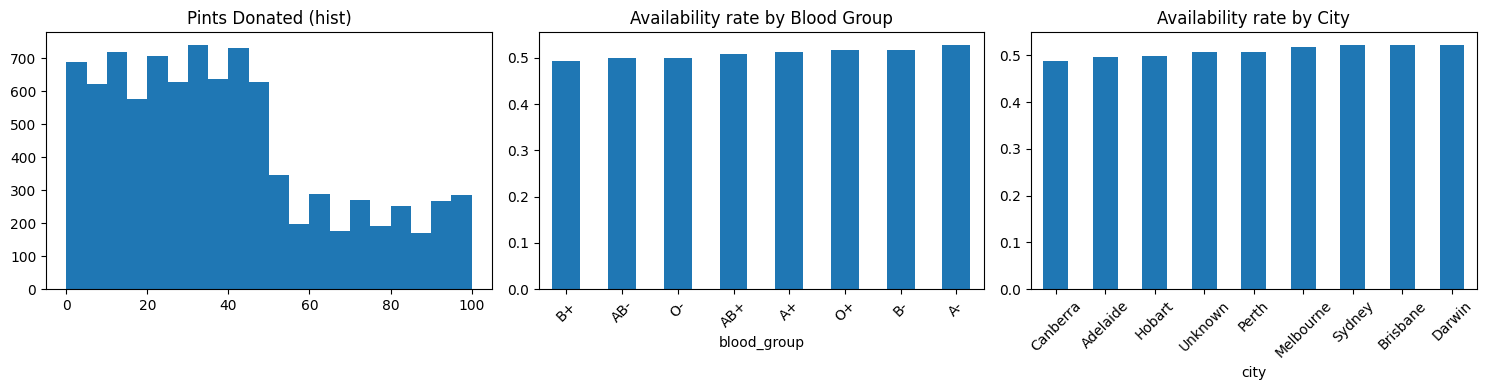

In [8]:

fig, axs = plt.subplots(1,3, figsize=(15,4))

if 'pints_donated' in df.columns:
    axs[0].hist(df['pints_donated'].dropna(), bins=20)
    axs[0].set_title('Pints Donated (hist)')
else:
    axs[0].axis('off')

if 'blood_group' in df.columns:
    (df.groupby('blood_group')[TARGET]
       .apply(lambda s: (s.astype(str).str.lower().isin(['yes','y','true','1']).mean()))
       .sort_values()
       .plot(kind='bar', ax=axs[1], rot=45, title='Availability rate by Blood Group'))
else:
    axs[1].axis('off')

if 'city' in df.columns:
    (df.groupby('city')[TARGET]
       .apply(lambda s: (s.astype(str).str.lower().isin(['yes','y','true','1']).mean()))
       .sort_values()
       .plot(kind='bar', ax=axs[2], rot=45, title='Availability rate by City'))
else:
    axs[2].axis('off')

plt.tight_layout()
plt.show()



## Step 8 — Feature selection (keep it small & clear)
**What we do:** Drop PII-like columns and derive simple date parts from `created_at` if available.

**Advantages**
- Protects privacy and prevents leakage
- Simple features stay explainable

In [9]:

drop_cols = [c for c in ['name','email','password','contact_number','donor_id'] if c in df.columns]
X = df.drop(columns=[TARGET] + drop_cols, errors='ignore').copy()

if 'created_at' in X.columns:
    dt = pd.to_datetime(X['created_at'], errors='coerce')
    X['created_at_year'] = dt.dt.year
    X['created_at_month'] = dt.dt.month
    X['created_at_day'] = dt.dt.day
    X = X.drop(columns=['created_at'])

cat_cols = [c for c in X.columns if X[c].dtype=='object']
num_cols = [c for c in X.columns if c not in cat_cols]

print('Categorical:', cat_cols)
print('Numerical  :', num_cols)


Categorical: ['city', 'blood_group']
Numerical  : ['months_since_first_donation', 'number_of_donation', 'pints_donated', 'created_at_year', 'created_at_month', 'created_at_day']



## Step 9 — Preprocessing pipeline
**What we do:** Define a single **ColumnTransformer** that imputes & encodes everything consistently.

**Advantages**
- Guarantees the same treatment during training & in the app
- Handles unknown categories gracefully

In [10]:

preprocess = ColumnTransformer(transformers=[
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler(with_mean=False))]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])



## Step 10 — Train/test split (stratified 80/20)
**What we do:** Hold out 20% for final sanity checks.

**Advantages**
- Prevents overfitting to cross-validation folds
- Gives a clean final metric for the demo

In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train:', X_train.shape, '| Test:', X_test.shape)


Train: (7640, 8) | Test: (1911, 8)



## Step 11 — Baseline: Logistic Regression
**What we do:** Train a simple, robust baseline with class_weight balancing.

**Advantages**
- Fast, transparent baseline
- Often competitive when features are well-prepared

F1-macro: 0.5194620423064533
ROC-AUC  : 0.5187131440141826
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       938
           1       0.53      0.53      0.53       973

    accuracy                           0.52      1911
   macro avg       0.52      0.52      0.52      1911
weighted avg       0.52      0.52      0.52      1911



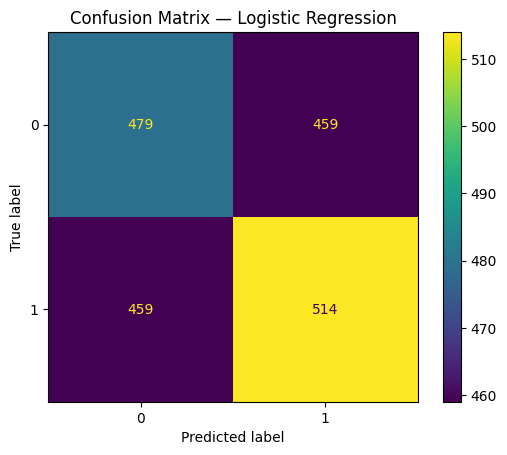

In [12]:

logreg = Pipeline([('pre', preprocess), ('clf', LogisticRegression(max_iter=300, class_weight='balanced'))])
logreg.fit(X_train, y_train)
yp = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)[:,1]

print('F1-macro:', f1_score(y_test, yp, average='macro'))
print('ROC-AUC  :', roc_auc_score(y_test, proba))
print(classification_report(y_test, yp))

ConfusionMatrixDisplay(confusion_matrix(y_test, yp)).plot()
plt.title('Confusion Matrix — Logistic Regression')
plt.show()



## Step 12 — Extra models & 5-fold CV leaderboard
**What we do:** Compare **Random Forest** and **SVC (RBF)** against our baseline with consistent cross-validation.

**Advantages**
- Fair model selection (same folds & metrics)
- Keeps the comparison small but meaningful

In [13]:

models = {
    'LogReg': LogisticRegression(max_iter=300, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', random_state=42),
    'SVC_RBF': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
}

def make_pipe(est):
    return Pipeline([('pre', preprocess), ('clf', est)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rows = []
for name, est in models.items():
    pipe = make_pipe(est)
    cvres = cross_validate(pipe, X, y, cv=cv,
                           scoring={'f1_macro':'f1_macro', 'roc_auc':'roc_auc'},
                           n_jobs=-1, return_train_score=False)
    rows.append({
        'model': name,
        'f1_macro_mean': cvres['test_f1_macro'].mean(),
        'roc_auc_mean': cvres['test_roc_auc'].mean()
    })
leaderboard = pd.DataFrame(rows).sort_values('f1_macro_mean', ascending=False)
leaderboard


,model,f1_macro_mean,roc_auc_mean
0,LogReg,0.499499,0.498342
1,RandomForest,0.487121,0.484883
2,SVC_RBF,0.337472,0.502832



## Step 13 — Choose a suitable model & evaluate on test
**What we do:** Pick the leaderboard winner (by F1-macro), fit on the training set, then evaluate on the held-out test set.

**Advantages**
- Transparent, metric-driven choice
- Final test metric separate from CV

Chosen model: LogReg
Final Test F1-macro: 0.5194620423064533
Final Test ROC-AUC  : 0.5187131440141826


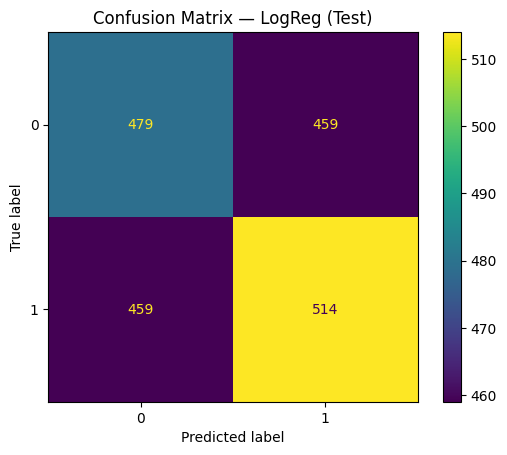

In [14]:

best_name = leaderboard.iloc[0]['model']
print('Chosen model:', best_name)

chosen_est = models[best_name]
final_pipe = make_pipe(chosen_est).fit(X_train, y_train)

yp_final = final_pipe.predict(X_test)
proba_final = final_pipe.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, yp_final, average='macro')
roc = roc_auc_score(y_test, proba_final)
print('Final Test F1-macro:', f1)
print('Final Test ROC-AUC  :', roc)

ConfusionMatrixDisplay(confusion_matrix(y_test, yp_final)).plot()
plt.title(f'Confusion Matrix — {best_name} (Test)')
plt.show()



## Step 14 — Save model artifact + tiny metrics JSON
**What we do:** Persist one pipeline (`final_model.pkl`) and a **very small** `metrics.json` the app can read.

**Advantages**
- App remains lightweight (load-and-predict)
- No manual preprocessing in the app (it’s inside the pipeline)

In [15]:

import joblib

metrics = {
    'model': str(best_name),
    'f1_macro': float(f1),
    'roc_auc': float(roc),
    'threshold': 0.50,
    'timestamp': int(time.time())
}
joblib.dump(final_pipe, MODELS_DIR / 'final_model.pkl')
with open(MODELS_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print('Saved:', MODELS_DIR / 'final_model.pkl')
print('Saved:', MODELS_DIR / 'metrics.json')


Saved: C:\Users\danan\Downloads\donor_app_full (3)\models\final_model.pkl
Saved: C:\Users\danan\Downloads\donor_app_full (3)\models\metrics.json



## Optional — Save a cleaned CSV (for transparency)
Useful if you want to share a tidy dataset version.


In [16]:

CLEAN = Path('data') / 'clean_donor.csv'
df.to_csv(CLEAN, index=False)
print('Saved cleaned CSV to:', CLEAN)


Saved cleaned CSV to: data\clean_donor.csv



---

### You're done 🎉
- You now have a **final_model.pkl** (preprocess + estimator) and **metrics.json**.
- The Streamlit app can load these files to make predictions and show a probability gauge and threshold slider.
